In [13]:

import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
sys.path.append(PROJECT_ROOT)

import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import modularized project code
from src.data.mnist_loader import MnistDataloader
from src.utils.preprocessing import preprocess_pipeline
from src.models.cnn import MNISTCNN
from src.training.engine import train_one_epoch, evaluate


In [14]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [15]:

input_path = os.path.join(PROJECT_ROOT, "data")

mnist = MnistDataloader(
    os.path.join(input_path, "train-images-idx3-ubyte/train-images-idx3-ubyte"),
    os.path.join(input_path, "train-labels-idx1-ubyte/train-labels-idx1-ubyte"),
    os.path.join(input_path, "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"),
    os.path.join(input_path, "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")
)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42, shuffle=True
    )

x_train, y_train = preprocess_pipeline(x_train, y_train, augment=True)
x_val, y_val = preprocess_pipeline(x_val, y_val, augment=False)

# Convert to tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=64, shuffle=False)


In [16]:

model = MNISTCNN().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [17]:

EPOCHS = 10
train_accs, test_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {test_acc:.4f}")


Epoch 1/10 | Train Acc: 0.9012 | Val Acc: 0.9837
Epoch 2/10 | Train Acc: 0.9632 | Val Acc: 0.9892
Epoch 3/10 | Train Acc: 0.9732 | Val Acc: 0.9905
Epoch 4/10 | Train Acc: 0.9781 | Val Acc: 0.9897
Epoch 5/10 | Train Acc: 0.9805 | Val Acc: 0.9923
Epoch 6/10 | Train Acc: 0.9835 | Val Acc: 0.9925
Epoch 7/10 | Train Acc: 0.9855 | Val Acc: 0.9927
Epoch 8/10 | Train Acc: 0.9870 | Val Acc: 0.9928
Epoch 9/10 | Train Acc: 0.9878 | Val Acc: 0.9923
Epoch 10/10 | Train Acc: 0.9886 | Val Acc: 0.9918


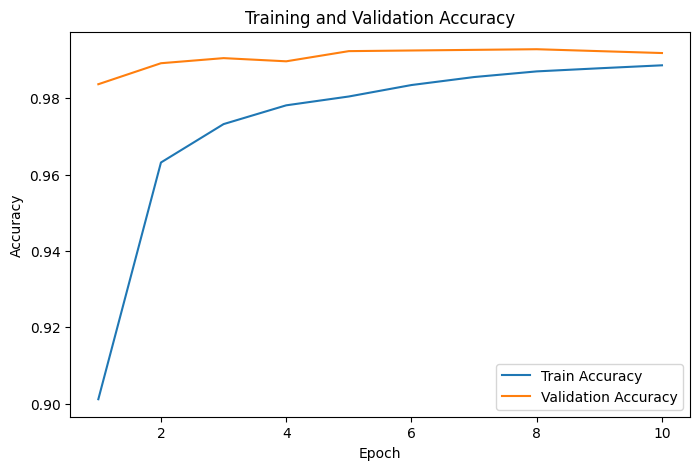

In [18]:
#Plot train/test accuracy
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_accs, label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), test_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
